# Pump Failure

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Main libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

main_data_path = '/content/drive/My Drive/Data Science/NarrativeWave/'

## EDA

In [2]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv(main_data_path + 'pump_failure.csv',parse_dates=['timestamp'])
df = df.drop_duplicates(subset=['timestamp'])
print("Number of measurements:",len(df['timestamp']))
df = df.set_index('timestamp')

Number of measurements: 22683


In [4]:
df.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


Measurement every 5 minutos. Indicate that to pandas dataframe.

In [5]:
df = df.asfreq('5min')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22683 entries, 2013-12-02 21:15:00 to 2014-02-19 15:25:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   22683 non-null  float64
dtypes: float64(1)
memory usage: 354.4 KB


No null values found in dataset. 

Check the distribution of the data. 

In [6]:
df.describe()

,value
count,22683.000000
mean,85.922359
std,13.749365
min,2.084721
25%,83.074740
50%,89.403332
75%,94.015731
max,108.510543


We can plot a histogram and a boxplot to visualize the distribution.

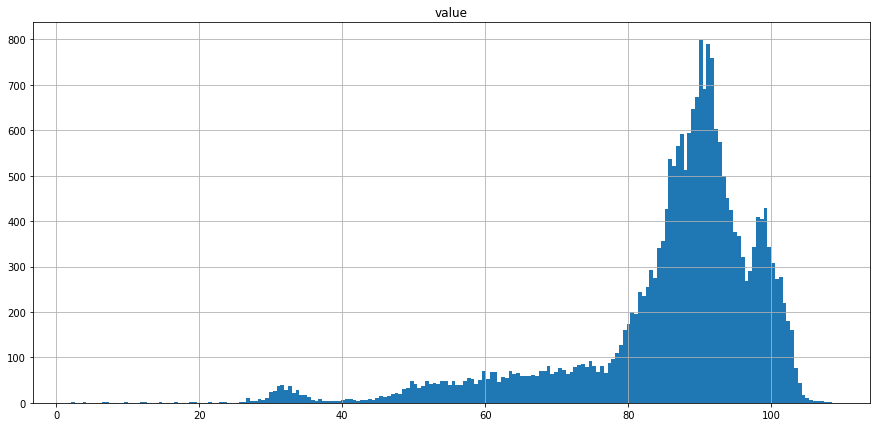

In [7]:
df.hist(figsize=(15,7), bins = 200);

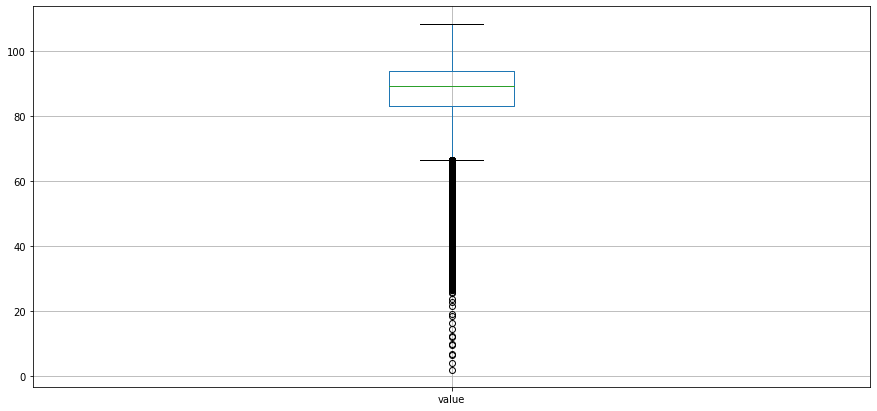

In [8]:
df.boxplot(figsize=(15,7));

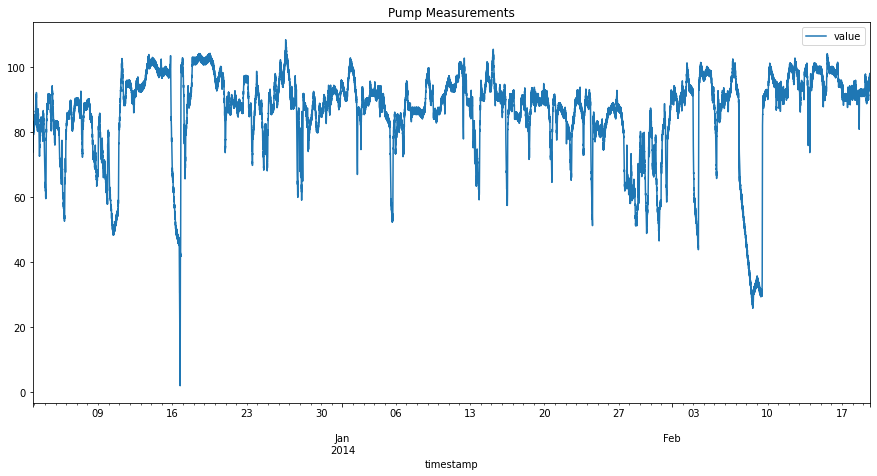

In [9]:
df.plot(figsize=(15,7));
plt.title('Pump Measurements');

From the plot above, it can be seen two main signal drops, the first one a pick almost reaching 0 and the second one close to 30 and continuing for some time there.

Before perfoming any model, it's good to check if the dataset is stationary.

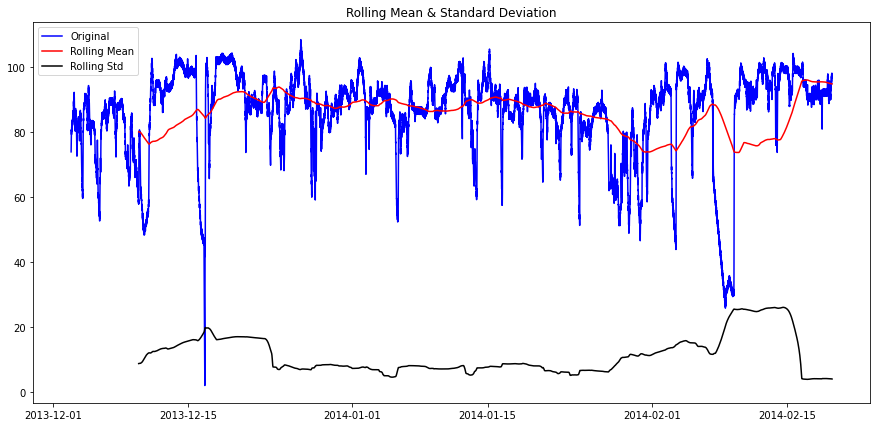

In [10]:
plt.figure(figsize=(15,7))
rolmean = df.rolling(2016).mean() #Week Window = 12 * 24 * 7 = 2016
rolstd = df.rolling(2016).std() #Week Window
_ = plt.plot(df, color='blue',label='Original')
_ = plt.plot(rolmean, color='red', label='Rolling Mean')
_ = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

Visually we can see in the plot above that the time serie is stationary (the mean and std devitation seem to be constant) but we'll create a statistical test just to confirm that.

In [11]:
dfueller = adfuller(df['value'])

In [13]:
print('ADF:',dfueller[0])
print('p-value:',dfueller[1])

ADF: -7.366851136211449
p-value: 9.188330601193214e-11


As p-value is lower than 0.05 we can reject the null hypothisis and consider the dataset as stationary. So there's no need to remove tendency and seasonality.

## Forecasting

For the forecasting a simple approach was chosen since the time serie is stationary, as confirmed in the last test.

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [35]:
forecast_model = SimpleExpSmoothing(df)
forecast_model_fit = forecast_model.fit(smoothing_level=0.6)

In order to have a better look, the prediction and visualization was narrowed to a spefic date range.

In [40]:
prediction = forecast_model_fit.predict(start='2014-02-18 13:25:00',end='2014-02-19 15:50:00')

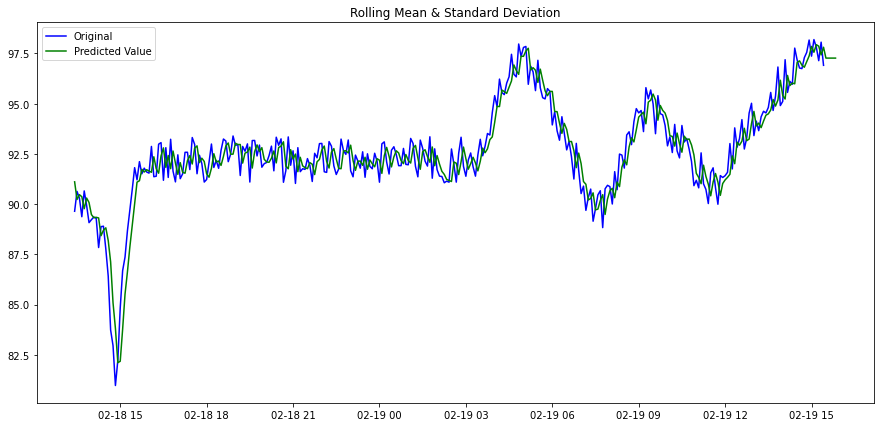

In [41]:
plt.figure(figsize=(15,7))
orig = plt.plot(df["2014-02-18 13:25:00":"2014-02-19 15:25:00"], color='blue',label='Original')
pre_plot = plt.plot(prediction, color='green', label='Predicted Value')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

The prediction was performed in the last part of the signal. At the end we can see that the value will remain constant (close to 97)

## Anomaly Detection

On this section, two approaches were performed. The first one, it's just a simple solution to detect an outlier based on the number of standar deviations a value is from the mean (z-score). The second approach is based on a machine learning model called IsolationForest.

The thershold to set a value as outlier was 2.5*std_dev

In [18]:
df_anom = df.copy()
mean = float(df.mean())
std = float(df.std())
df_anom['z_score'] = (df['value'] - mean)/std
df_anom['z_outlier'] = abs(df_anom['z_score'])>2.5
df_anom['z_outlier'].value_counts()

False    21889
True       794
Name: z_outlier, dtype: int64

In [19]:
df_anom_z = df_anom[['value','z_outlier']]
df_anom_z = df_anom_z[df_anom_z['z_outlier']==True]

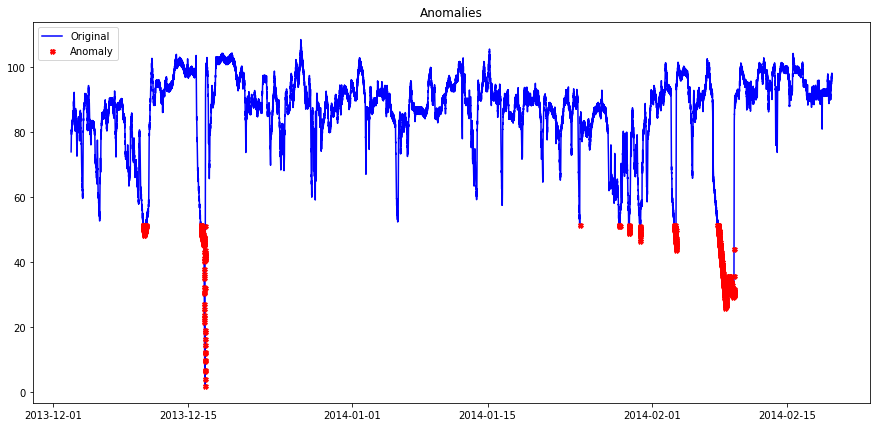

In [20]:
plt.figure(figsize=(15,7))
_ = plt.plot(df, color='blue',label='Original')
_ = plt.plot(df_anom_z['value'], linestyle='none', marker='X', color='red', markersize=5, label='Anomaly')
plt.legend(loc='best')
plt.title('Anomalies')
plt.show()

Zoom-in to the worst case scenario.

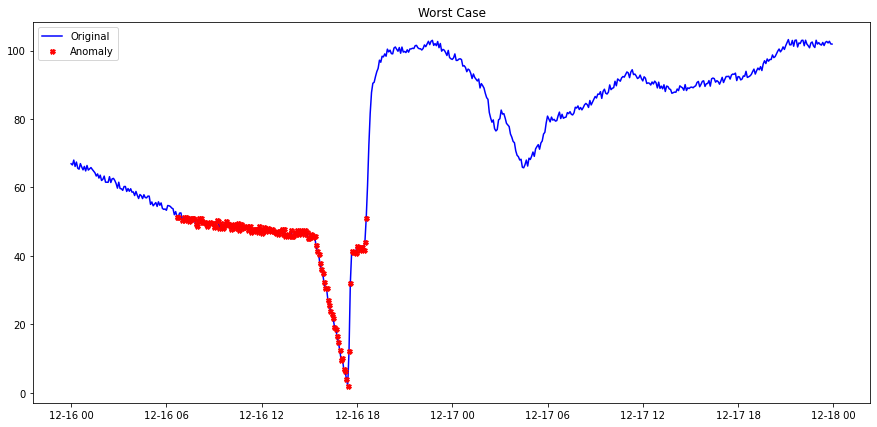

In [21]:
plt.figure(figsize=(15,7))
_ = plt.plot(df['2013-12-16':'2013-12-17'], color='blue',label='Original')
_ = plt.plot(df_anom_z['2013-12-16':'2013-12-17']['value'], linestyle='none', marker='X', color='red', markersize=5, label='Anomaly')
plt.legend(loc='best')
plt.title('Worst Case')
plt.show()

In [22]:
from sklearn.ensemble import IsolationForest

In [42]:
if_model =  IsolationForest(contamination=0.10,random_state=42)
if_model_fit = if_model.fit(df)
df_anom['predicted'] = if_model_fit.predict(df)
df_anom['predicted'].value_counts()

 1    20418
-1     2265
Name: predicted, dtype: int64

In [43]:
df_anom_if = df_anom[['value','predicted']]
df_anom_if = df_anom_if[df_anom_if['predicted']==-1]

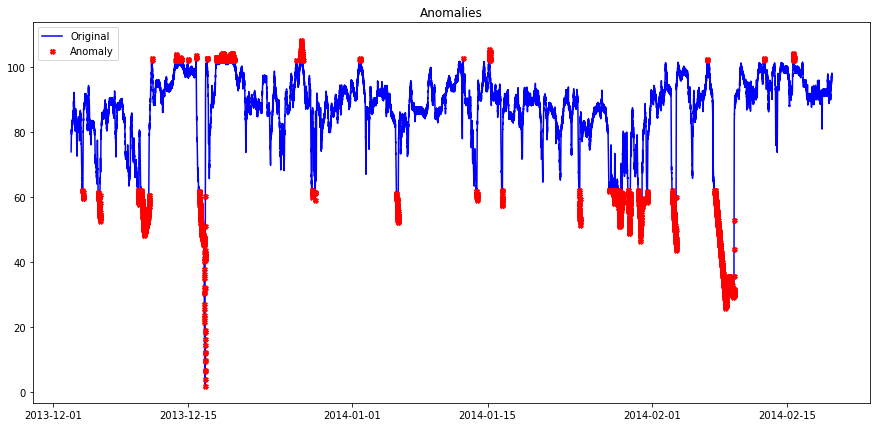

In [44]:
plt.figure(figsize=(15,7))
_ = plt.plot(df, color='blue',label='Original')
_ = plt.plot(df_anom_if['value'], linestyle='none', marker='X', color='red', markersize=5, label='Anomaly')
plt.legend(loc='best')
plt.title('Anomalies')
plt.show()

There are more outliers detected from the IsolationForest model even thogh a low contamination percentage was set. This evaluation could be confirmed by corralating the signals with other sensors or knowing the correct performance of the pump.

# Failure Prediction

A LSTM neural network was chosen to predict if a continous measurments indicate that the pump will suffer from a failure.

In [26]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

This is a binary classification, having 1 when the pump has a failure. A failure in this case scenario was selected when an outlier is detected.

In [27]:
mean = float(df.mean())
std = float(df.std())
df_failures = df.copy()
df_failures['z_score'] = (df['value'] - mean)/std
df_failures['z_outlier'] = abs(df_anom['z_score'])>2.5
Y = df_failures['z_outlier'].to_numpy()

In [28]:
#Normalize the data to work with the LSTM neural network
scaler = MinMaxScaler(feature_range=(0, 1))
df_failures = df_failures[['value']]
X = scaler.fit_transform(df_failures)
X = X.reshape(22683)

Create the supervised dataset by creating sequence of measurments and assigning 1 as label if at least one outlier is present.
The sequence length can be changed depending on how early we want to predict a failure. In  this case, lenght of 12 was chosen meaning 1 hour earlier.

In [29]:
sequence_length = 12 #5T * 12 = 60 min
features = 1
data_X = []
data_Y = []
for i in range(len(X)-sequence_length-1):
    data_X.append(X[i:i+sequence_length])
    outlier = False
    for j in range(sequence_length):
        if Y[i+j] == 1:
            outlier = True
    if outlier:
        data_Y.append(1)
    else:
        data_Y.append(0)
        
data_X = np.array(data_X)
data_Y = np.array(data_Y)
print(data_X.shape)
print(data_Y.shape)
data_X = data_X.reshape(data_X.shape[0],data_X.shape[1],features)
print(data_X.shape)

(22670, 12)
(22670,)
(22670, 12, 1)


Create dataset for training:

In [30]:
test_split = 0.2
train_size = int(len(data_X) * (1 - test_split))
X_train = data_X[:train_size]
y_train = data_Y[:train_size]
X_test = data_X[train_size:]
y_test =data_Y[train_size:]

Create a simple LSTM model for binary classification.

In [31]:
model = Sequential()
model.add(LSTM(25, activation = 'relu',return_sequences=False,input_shape=(sequence_length,features)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                2700      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [32]:
h = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
567/567 [==============================] - 5s 6ms/step - loss: 0.2051 - accuracy: 0.9769
Epoch 2/5
567/567 [==============================] - 3s 6ms/step - loss: 0.0229 - accuracy: 0.9915
Epoch 3/5
567/567 [==============================] - 3s 5ms/step - loss: 0.0202 - accuracy: 0.9929
Epoch 4/5
567/567 [==============================] - 3s 5ms/step - loss: 0.0220 - accuracy: 0.9924
Epoch 5/5
567/567 [==============================] - 3s 5ms/step - loss: 0.0172 - accuracy: 0.9938


Test the model and print those data sequence that have a probability between 80% and 90% to fail.

In [33]:
m_pred=model.predict(X_test)
for i,x in enumerate(m_pred):
  temp = x[0]*100
  if temp > 80.0 and temp < 90.0:
    print(scaler.inverse_transform(X_test[i]), "Probability:", round(x[0]*100,2))

[[48.62938293]
 [49.12552808]
 [50.3515059 ]
 [48.93097271]
 [50.50442682]
 [49.92951294]
 [49.44730018]
 [49.59755235]
 [49.71708375]
 [49.10182838]
 [48.97980874]
 [49.57133942]] Probability: 80.13
[[49.44730018]
 [49.59755235]
 [49.71708375]
 [49.10182838]
 [48.97980874]
 [49.57133942]
 [49.35000845]
 [49.51040382]
 [47.52361042]
 [48.46513678]
 [48.92819317]
 [47.53537232]] Probability: 81.18
[[49.59755235]
 [49.71708375]
 [49.10182838]
 [48.97980874]
 [49.57133942]
 [49.35000845]
 [49.51040382]
 [47.52361042]
 [48.46513678]
 [48.92819317]
 [47.53537232]
 [47.44274773]] Probability: 81.9
[[49.71708375]
 [49.10182838]
 [48.97980874]
 [49.57133942]
 [49.35000845]
 [49.51040382]
 [47.52361042]
 [48.46513678]
 [48.92819317]
 [47.53537232]
 [47.44274773]
 [48.501459  ]] Probability: 83.05
[[49.10182838]
 [48.97980874]
 [49.57133942]
 [49.35000845]
 [49.51040382]
 [47.52361042]
 [48.46513678]
 [48.92819317]
 [47.53537232]
 [47.44274773]
 [48.501459  ]
 [47.59503947]] Probability: 84.51
[